In [1]:
#set up pyspark
import os
import pyspark
from pyspark.sql import functions as f

conf = pyspark.SparkConf()

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/14 23:06:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [2]:
with open("shared/students/Toys_and_Games_Unlabelled.json", "r") as input_file:
    # Read the first 500 lines of the input file
    lines = input_file.readlines()[:10]

# Have a look at the dataset, cannot have a preview of 3.9G 
with open("output.txt", "w") as output_file:
    # Write the first 500 lines to the output file
    output_file.write("".join(lines))

In [3]:
from pyspark.sql.types import StructType, StructField, StringType,BooleanType, IntegerType, DoubleType

# Define the schema for the data to clean the data
# Some lines of data has image field...
schema = StructType([
    StructField("overall", DoubleType(), True),
    StructField("vote", StringType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID",StringType(), True),
    StructField("asin",StringType(), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", StringType(), True),
])
df = spark.read.json("shared/students/Toys_and_Games_Unlabelled.json", schema=schema)
df.show()

+-------+----+--------+-----------+--------------+----------+--------------------+--------------------+--------------+
|overall|vote|verified| reviewTime|    reviewerID|      asin|        reviewerName|          reviewText|unixReviewTime|
+-------+----+--------+-----------+--------------+----------+--------------------+--------------------+--------------+
|    2.0|  12|   false|09 22, 2016|A1IDMI31WEANAF|0020232233|      Mackenzie Kent|When it comes to ...|    1474502400|
|    1.0|  21|   false|09 18, 2016| A4BCEVVZ4Y3V3|0020232233|  Jonathan Christian|An Open Letter to...|    1474156800|
|    3.0|  19|    true|09 12, 2016|A2EZ9PY1IHHBX0|0020232233|     unpreparedtodie|Nice art, nice pr...|    1473638400|
|    5.0|null|    true| 03 2, 2017|A139PXTTC2LGHZ|0020232233|              Ashley|Amazing buy! Boug...|    1488412800|
|    1.0|   3|    true| 02 8, 2017|A3IB33V29XIL8O|0020232233|            Oghma_EM|As my review of G...|    1486512000|
|    5.0|null|    true|01 27, 2017|A1J86V48S4KRJ

In [4]:
from pyspark.sql.functions import date_format,to_date,from_unixtime,col,year
from pyspark.sql.types import TimestampType,LongType,DateType
new_df=df.withColumn("date", to_date(from_unixtime(col("unixReviewTime"))))
new_df=new_df.withColumn("year", year(col('date')))
new_df.show(5)
new_df=new_df.drop('reviewerName').drop('unixReviewTime')
new_df.show()

+-------+----+--------+-----------+--------------+----------+------------------+--------------------+--------------+----------+----+
|overall|vote|verified| reviewTime|    reviewerID|      asin|      reviewerName|          reviewText|unixReviewTime|      date|year|
+-------+----+--------+-----------+--------------+----------+------------------+--------------------+--------------+----------+----+
|    2.0|  12|   false|09 22, 2016|A1IDMI31WEANAF|0020232233|    Mackenzie Kent|When it comes to ...|    1474502400|2016-09-21|2016|
|    1.0|  21|   false|09 18, 2016| A4BCEVVZ4Y3V3|0020232233|Jonathan Christian|An Open Letter to...|    1474156800|2016-09-17|2016|
|    3.0|  19|    true|09 12, 2016|A2EZ9PY1IHHBX0|0020232233|   unpreparedtodie|Nice art, nice pr...|    1473638400|2016-09-11|2016|
|    5.0|null|    true| 03 2, 2017|A139PXTTC2LGHZ|0020232233|            Ashley|Amazing buy! Boug...|    1488412800|2017-03-01|2017|
|    1.0|   3|    true| 02 8, 2017|A3IB33V29XIL8O|0020232233|        

1. Number of ratings graph

In [ ]:
!pip install matplotlib

+-------+-------+
|overall|  count|
+-------+-------+
|    5.0|5375966|
|    4.0|1126574|
|    3.0| 609097|
|    2.0| 382567|
|    1.0| 707027|
+-------+-------+

root
 |-- overall: double (nullable = true)
 |-- count: long (nullable = false)



Text(0.5, 0, 'Review Score')

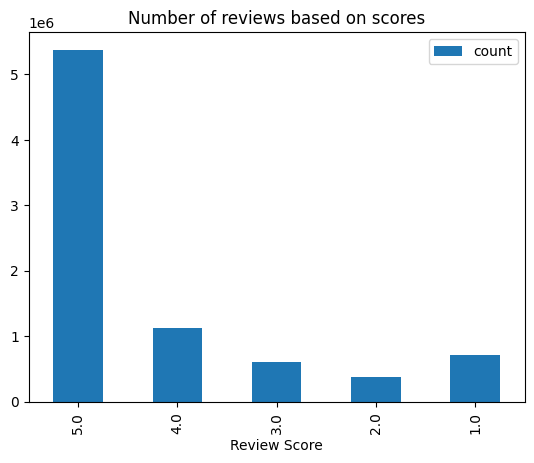

In [5]:
# Number of ratings graph
from pyspark.sql.functions import col,desc,asc
rating_df=new_df.groupBy('overall').count().sort(desc('overall'))
rating_df=rating_df.withColumn("overall", col("overall"))
rating_df.show(10)
rating_df.printSchema()

# pd_df = pd.DataFrame(rating_df, ["review/score", "count"])
# fig = px.bar(pd_df, x="review/score", y="count")
panda_rating_df=rating_df.toPandas()
# # Show the graph
# fig.show()
panda_rating_df.plot.bar(x='overall', y='count',title="Number of reviews based on scores") 

import matplotlib.pyplot as plt
# Get the current Axes object
ax = plt.gca()
# Set the x-axis label
ax.set_xlabel("Review Score") 
#rating_df.bar("review/score", "count", title="Bar Graph")

2. Rating Distribution Graph

In [ ]:
!pip install seaborn

In [ ]:
# Rating Distribution graph
import seaborn as sns
new_df=new_df.withColumn("review/score", col("review/score").cast('double')) 
panda_new_df=new_df.toPandas()
sns.boxplot(x="review/score", data=panda_new_df, whis=5, showmeans=True, meanline=True)
# panda_new_df['review/score'].plot.box()
############################################################################### 
#Code works fine on smaller dataset (can use the output image from Google Colab)

3. Product frequency with Average rating

+----------+-----+------------------+
|      asin|count|      avg(overall)|
+----------+-----+------------------+
|B000YDDF6O|12680| 4.695583596214511|
|B004S8F7QM| 8816|4.7334392014519056|
|B010TQY7A8| 7487|4.5094163216241485|
|B00WR5357G| 6617| 4.788574882877437|
|B003UCODIA| 6188| 3.961861667744021|
|B00MNG37C2| 4639| 3.951929295106704|
|B000WD3XBI| 4590|3.9278867102396515|
|B01H1NV1RE| 4340| 4.427649769585253|
|B00U78NQHO| 4225| 4.422958579881657|
|B010TU7LP2| 4197| 4.349297116988325|
+----------+-----+------------------+
only showing top 10 rows



Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:571)
	at java.net.ServerSocket.accept(ServerSocket.java:534)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


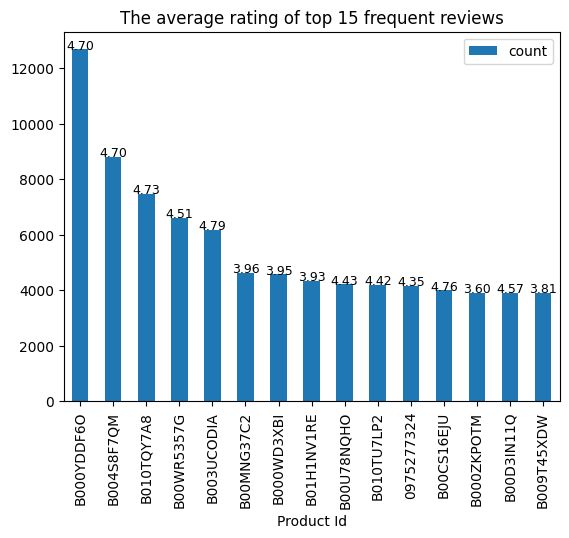

In [8]:
average_df = new_df.groupBy('asin') \
                     .avg('overall') \
                     .alias('average_rating')

frequency_df= new_df.groupBy('asin') \
                     .count()

result_df = frequency_df.join(average_df, average_df['asin'] == frequency_df['asin'],"inner")

# The top 15
result_df_desc=result_df.sort(desc('count')).drop(col('average_rating.asin')).limit(15)
result_df_desc.show(10)
panda_result_df_desc=result_df_desc.toPandas()
panda_result_df_desc.plot.bar(x='asin', y='count',title='The average rating of top 15 frequent reviews') 
ax = plt.gca()
ax.set_xlabel("Product Id") 
# for p in ax.patches:
#     ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{:.2f}'.format(panda_result_df_desc['avg(review/score)'][int(p.get_x())]), ha="center")
for p in ax.patches:
    # Calculate the coordinates for the text annotation
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    # Add the text annotation
    ax.text(x, y, '{:.2f}'.format(panda_result_df_desc['avg(overall)'][int(p.get_x())]), ha="center",fontsize=9)



+----------+-----+------------+
|      asin|count|avg(overall)|
+----------+-----+------------+
|0735324239|    1|         5.0|
|0764973991|    1|         2.0|
|0735327408|    1|         5.0|
|0004950763|    1|         5.0|
|0735328757|    1|         2.0|
|0298770016|    1|         5.0|
|0735331251|    1|         5.0|
|0399232133|    1|         5.0|
|0735334358|    1|         5.0|
|0547775520|    1|         1.0|
+----------+-----+------------+
only showing top 10 rows



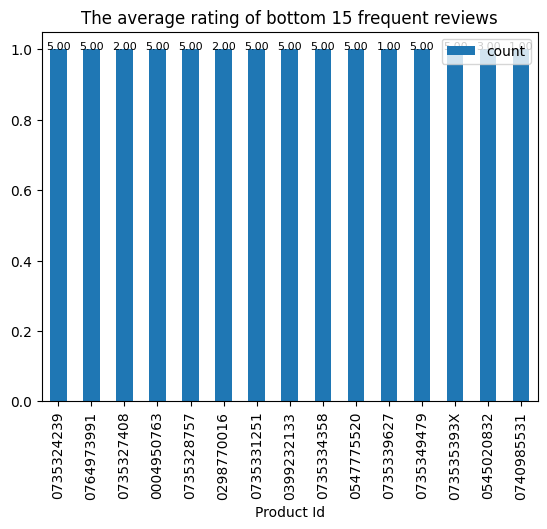

In [9]:
# The lowest 15
result_df_asc=result_df.sort(asc('count')).drop(col('average_rating.asin')).limit(15)
result_df_asc.show(10)
panda_result_df_asc=result_df_asc.toPandas()
panda_result_df_asc.plot.bar(x='asin', y='count',title='The average rating of bottom 15 frequent reviews') 
ax = plt.gca()
ax.set_xlabel("Product Id") 
# for p in ax.patches:
#     ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{:.2f}'.format(panda_result_df_desc['avg(review/score)'][int(p.get_x())]), ha="center")
for p in ax.patches:
    # Calculate the coordinates for the text annotation
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    # Add the text annotation
    ax.text(x, y, '{:.2f}'.format(panda_result_df_asc['avg(overall)'][int(p.get_x())]), ha="center",fontsize=8)